In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm
import pandas as pd

In [2]:
class SOM:
    
    def __init__(self, input_dim, dim=10, sigma=None, learning_rate=0.1, tau2=1000):
        if sigma is None:
            self.sigma = dim / 2
        else:
            self.sigma = sigma
        self.learning_rate = learning_rate
        self.input_dim = input_dim
        self.tau1 = 1000 / np.log(self.sigma)
        self.tau2 = tau2
        self.dim = dim # будет квадратная сетка
        self.activation_map = np.zeros((dim, dim))
        self.weights = np.random.uniform(-1,1, (dim, dim, input_dim))
        # self.positions = np.indices((dim, dim)).transpose((1,2,0)).reshape(-1,2)
        self.x_coordinates = np.arange(dim)
        self.y_coordinates = np.arange(dim)
        

    def get_weights(self):
        return self.weights

    def _decay_function(self, decay_rate, iteration, temperature):
        return decay_rate * np.exp( (-iteration) / temperature)

    def activate(self, sample):
        self._activate(sample)
        return self.activation_map

    def _activate(self, sample):
        grid_difference = np.subtract(sample, self.weights)
        iterator = np.nditer(self.activation_map, flags=['multi_index'])
        while not iterator.finished:
            self.activation_map[iterator.multi_index] = np.linalg.norm(grid_difference[iterator.multi_index])
            iterator.iternext()

    def calculate_winner(self, sample):
        self._activate(sample)
        winner_argmin = self.activation_map.argmin()
        winner_coord = np.unravel_index(winner_argmin, self.activation_map.shape)
        return winner_coord

    # def neighborhood_func(self, coord, sigma):
        # var = sigma * sigma
        # return np.exp(-np.sum(np.power(self.positions - coord, 2), axis=1) / 2 / var).reshape(self.dim, self.dim)

    def neighborhood_func(self, coord, sigma):
        x_center = coord[0]
        y_center = coord[1]
        variance = sigma*sigma
        gaussian_x = np.exp(-np.power(self.x_coordinates-x_center,2)/(2*variance))
        gaussian_y = np.exp(-np.power(self.y_coordinates-y_center,2)/(2*variance))
        gaussian_neighborhood = np.outer(gaussian_x,gaussian_y)
        return gaussian_neighborhood

    def update(self, sample, winner_coord, iter_num):
        eta = self._decay_function(self.learning_rate, iter_num, self.tau2)
        sig = self._decay_function(self.sigma, iter_num, self.tau1)
        neighbors_dist = eta * self.neighborhood_func(winner_coord, sig)

        iterator = np.nditer(neighbors_dist, flags=['multi_index'])
        while not iterator.finished:
            self.weights[iterator.multi_index] = (self.weights[iterator.multi_index] + 
                                                  neighbors_dist[iterator.multi_index] *
                                                  (sample - self.weights[iterator.multi_index])
                                                )
            iterator.iternext()

    def fit(self, data, n_iters):
        for i in tqdm(range(n_iters)):
            sample = data[np.random.choice(len(data), 1)]
            self.update(sample, self.calculate_winner(sample), i)

In [3]:
def plot_weight_winner(X, y, model, dataset_name=''):
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    n_classes = len(np.unique(y))
    for sample,number in tqdm(zip(X, y)):
        winner = model.calculate_winner(sample)
        x_coordinate = winner[0]
        y_coordinate = winner[1]
        
        num_colors = plt.cm.jet(number / n_classes)
        plt.text(x_coordinate, y_coordinate,
                 str(number), color=num_colors,
                 fontdict={'weight':'bold', 'size':15})

    plt.ylim(-.5, 40.5)
    plt.xlim(-.5, 40.5)
    plt.title('SOM applied to ' + dataset_name)
    plt.show()

## MNIST

In [4]:
from sklearn.datasets import load_digits, load_breast_cancer, load_iris

In [5]:
model = SOM(64, dim=40, sigma=9, learning_rate=0.5)
digits = load_digits(n_class=10)
data = digits.data 
numbers = digits.target
model.fit(data, 1000)

100%|██████████| 1000/1000 [00:35<00:00, 28.22it/s]


1797it [00:31, 56.62it/s]


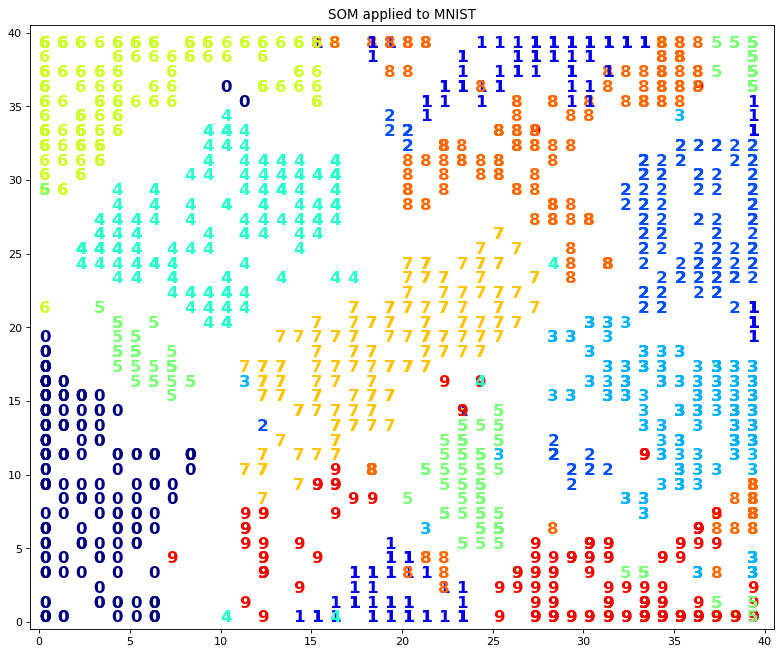

CPU times: user 38 s, sys: 1.9 s, total: 39.9 s
Wall time: 39 s


In [6]:
%%time
plot_weight_winner(data, numbers, model, 'MNIST')

## Colors

In [7]:
model = SOM(3, dim=20)
test_data = np.random.uniform(0, 1, (25000, 3))
model.fit(test_data, 10000)

100%|██████████| 10000/10000 [01:37<00:00, 102.91it/s]


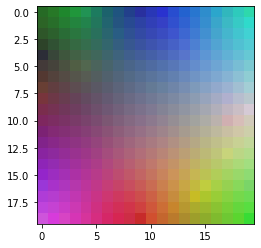

In [8]:
plt.imshow(model.weights)

## Iris

In [9]:
X, y = load_iris().data, load_iris().target

In [10]:
model = SOM(X.shape[1], 40)
model.fit(X, 1000)

100%|██████████| 1000/1000 [00:36<00:00, 27.27it/s]


150it [00:02, 56.20it/s]


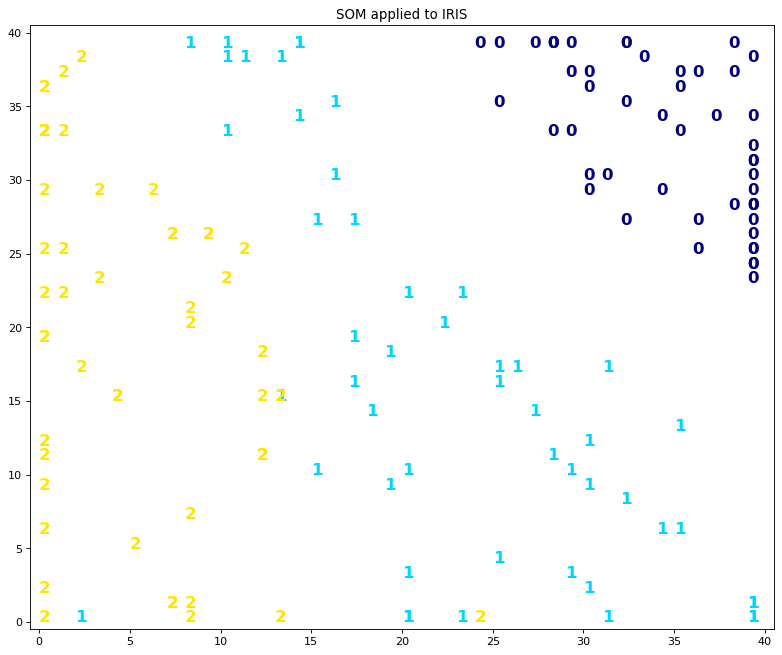

CPU times: user 3.4 s, sys: 335 ms, total: 3.73 s
Wall time: 3.49 s


In [11]:
%%time
plot_weight_winner(X, y, model, 'IRIS')

## Breast Cancer

In [12]:
X, y = load_breast_cancer().data, load_breast_cancer().target

In [13]:
model = SOM(X.shape[1], 40)
model.fit(X, 10000)

100%|██████████| 10000/10000 [06:03<00:00, 27.49it/s]


569it [00:10, 54.32it/s]


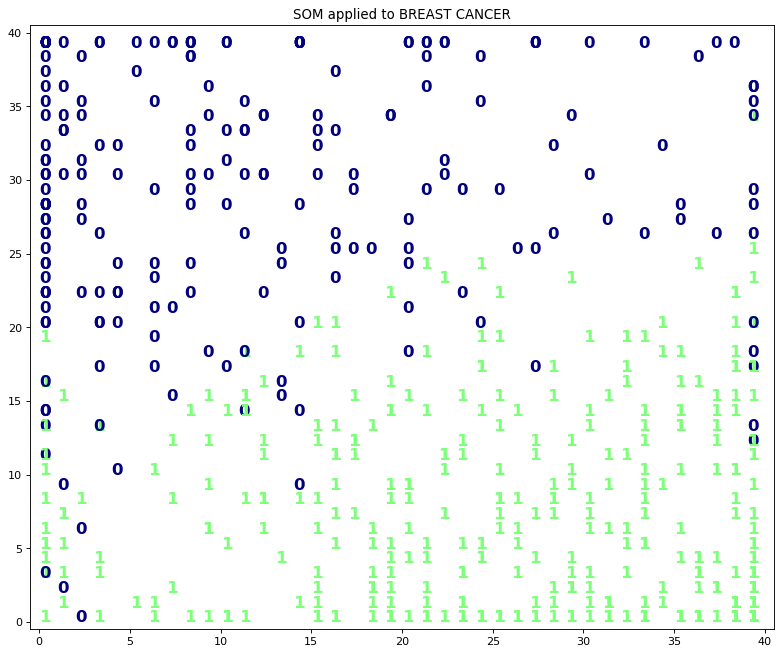

CPU times: user 12.9 s, sys: 888 ms, total: 13.7 s
Wall time: 13.1 s


In [14]:
%%time
plot_weight_winner(X, y, model, 'BREAST CANCER')

## Churn

dataset: https://www.kaggle.com/c/advanced-dls-spring-2021

In [15]:
df = pd.read_csv('../intro_ml/lr2/train.csv')
print(df.shape)
df.head()

(5282, 20)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


<AxesSubplot:xlabel='Churn', ylabel='count'>

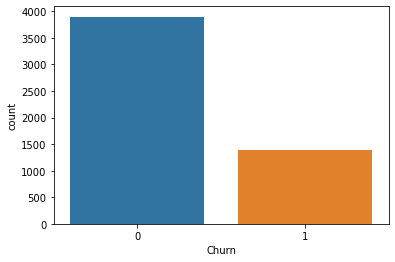

In [16]:
sns.countplot(data=df, x='Churn')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [18]:
df.TotalSpent = df.TotalSpent.apply(lambda x: x if x != ' ' else np.nan)
df.TotalSpent = df.TotalSpent.apply(float)

In [19]:
df.dropna(inplace=True)

In [20]:
numeric_cols = df._get_numeric_data().columns.to_list()
categorical_cols = list(set(df.columns) - set(numeric_cols))

In [21]:
cat_cols = pd.get_dummies(df[categorical_cols])

In [22]:
df = pd.concat([df[numeric_cols], cat_cols], axis=1)
df.dropna(inplace=True)
df.shape

(5273, 46)

In [23]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
model = SOM(X.shape[1], 40)
model.fit(X, 10000)

100%|██████████| 10000/10000 [06:01<00:00, 27.65it/s]


5273it [01:33, 56.37it/s]


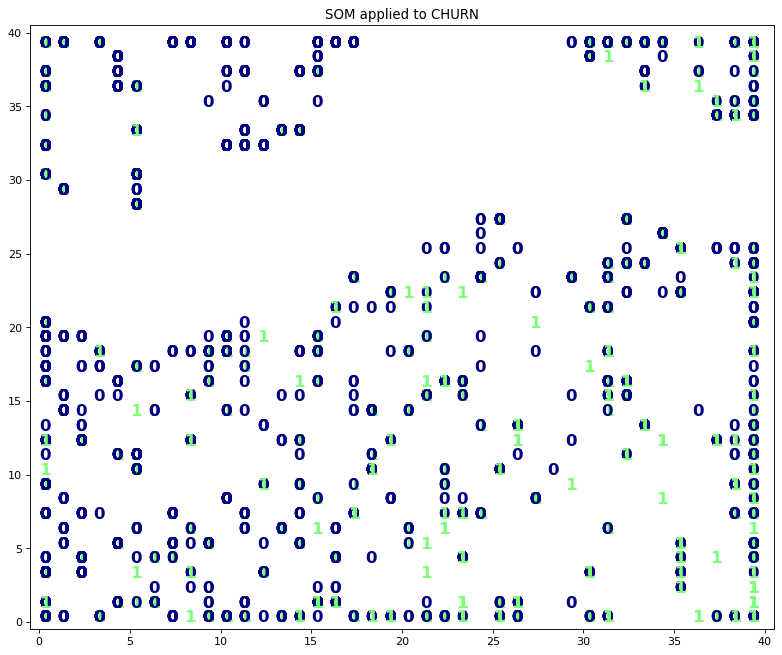

CPU times: user 1min 50s, sys: 6.06 s, total: 1min 56s
Wall time: 1min 52s


In [27]:
%%time
plot_weight_winner(X, y, model, 'CHURN')